<a href="https://colab.research.google.com/github/chequanghuy/CS114.K21/blob/master/CaseStudy/Leaf-CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import thư viện

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
import numpy as np
import random
import os
import matplotlib.pyplot as plt 
import pandas as pd
import cv2

Using TensorFlow backend.


# Truy cập vào drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Colab\ Notebooks/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Lưu lại đường dẫn ảnh

In [ ]:
#Lấy tất cả đường đẫn đến ảnh 
filenames=os.listdir("Folio/")
print(filenames)
labels=[]
paths=[]
images=[]
images_test=[]
c=0
for i in filenames:
    path=os.path.join("Folio/",i)
    file_images=os.listdir(path)
    c=0
    for j,f in enumerate(file_images):
        image=os.path.join(path,f)
        if c<4:
          images_test.append(image)
        else:
          images.append(image)
        c=c+1
    
#Xáo trộn đường dẫn
random.shuffle(images)
random.shuffle(images_test)

['chrysanthemum', 'ashanti blood', 'coeur demoiselle', 'bitter orange', 'betel', 'chocolate tree', 'chinese guava', 'beaumier du perou', 'caricature plant', 'barbados cherry', 'fruitcitere', 'croton', 'guava', 'geranium', 'duranta gold', 'jackfruit', 'ficus', 'coffee', 'hibiscus', 'eggplant', 'rose', 'papaya', 'lychee', 'ketembilla', 'pimento', 'thevetia', 'star _apple', 'sweet_olive', 'sweet_potato', 'mulberry_leaf', 'pomme_jacquot', 'vieux_garcon']


# Label dữ liệu

In [ ]:
# Đường dẫn ảnh sẽ là dataset/tên_lá/tên_ảnh ví dụ dataset/Bluebell/image_0241.jpg nên p.split(os.path.sep)[-2] sẽ lấy ra được tên lá
y_train = [p.split(os.path.sep)[-2] for p in images]
y_test = [p.split(os.path.sep)[-2] for p in images_test]
# Chuyển tên các loài hoa thành số
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


In [ ]:
# One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# Đọc ảnh

In [ ]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
X_train = []
X_test=[]
for (j, imagePath) in enumerate(images):
    image = cv2.imread(imagePath)
    X_train.append(cv2.resize(image, (224,224)))
for (j, imagePath) in enumerate(images_test):
    image = cv2.imread(imagePath)
    X_test.append(cv2.resize(image, (224,224)))
X_train = np.array(X_train)
X_test = np.array(X_test)

# Thống kê dữ liệu

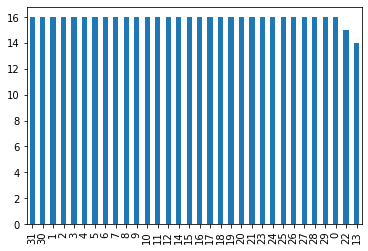

In [ ]:
df = pd.DataFrame({
    'train_label': y_train,
})
df['train_label'].value_counts().plot.bar()

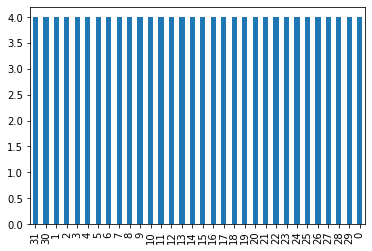

In [ ]:
df = pd.DataFrame({
    'test_label': y_test,
})
df['test_label'].value_counts().plot.bar()

# Augment data

Augment data zoom ảnh lên 20% và flip ảnh

In [ ]:
# augmentation cho training data
aug_train = ImageDataGenerator(rescale=1./255, 
                         zoom_range=0.2, horizontal_flip=True,
                         fill_mode='nearest')
# augementation cho test
aug_test= ImageDataGenerator(rescale=1./255)

In [ ]:
example_generator=aug_train.flow(X_train, y_train)

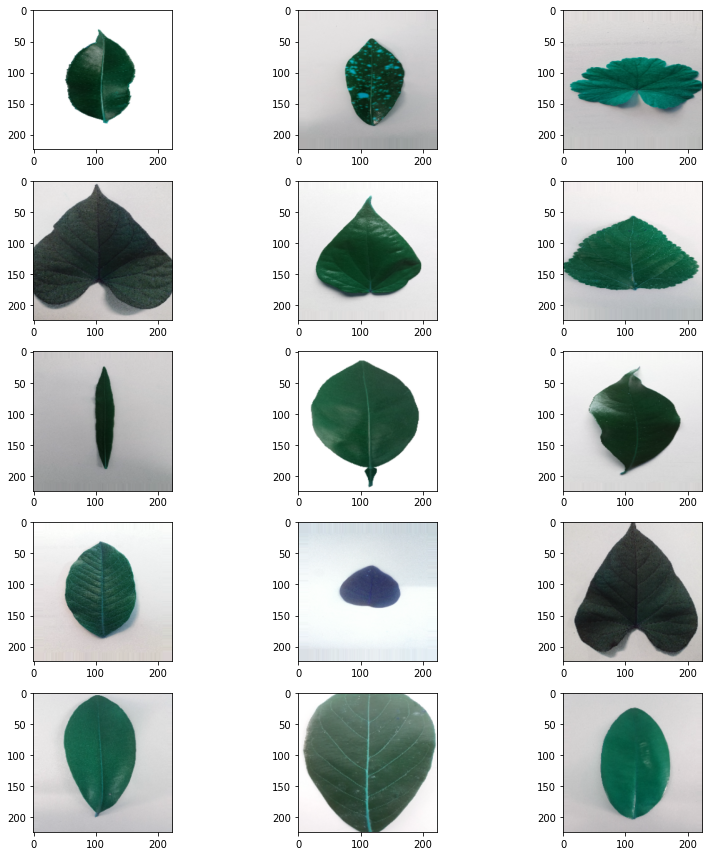

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Tranfer learning

Sử dụng pretrained model VGG16, bỏ đi các fully connected layer, thêm một số fully connected layer mới

In [ ]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers

baseModel = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Lấy output của ConvNet trong VGG16
fcHead = baseModel.output
# Flatten trước khi dùng FCs
fcHead = Flatten(name='flatten')(fcHead)

# Thêm FC
fcHead = Dense(256, activation='relu')(fcHead)
fcHead = Dropout(0.3)(fcHead)

# Output layer với softmax activation
fcHead = Dense(32, activation='softmax')(fcHead)

# Xây dựng model bằng việc nối ConvNet của VGG16 và fcHead
model = model = Model(inputs=baseModel.input, outputs=fcHead)
model.summary()


58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

# Setup callback

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
earlystop = EarlyStopping(patience=15)
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = ModelCheckpoint("models_1/model-{epoch:03d}.h5",
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='auto')
callbacks = [earlystop,learning_rate_reduction,checkpoint]

# Traning

freeze các fully connected layer, training để cập nhật các layer của VGG16 5 epochs

In [ ]:
opt = RMSprop(0.001)

numOfEpoch = 5
# freeze VGG model
for layer in model.layers[0:len(baseModel.layers)]:
    layer.trainable = False
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch)

Epoch 1/5
15/15 [==============================] - 17s 1s/step - loss: 7.4628 - accuracy: 0.1195 - val_loss: 2.3607 - val_accuracy: 0.5703
Epoch 2/5
15/15 [==============================] - 7s 436ms/step - loss: 1.9891 - accuracy: 0.4549 - val_loss: 1.6173 - val_accuracy: 0.6641
Epoch 3/5
15/15 [==============================] - 6s 424ms/step - loss: 1.7046 - accuracy: 0.5178 - val_loss: 0.6856 - val_accuracy: 0.7891
Epoch 4/5
15/15 [==============================] - 6s 415ms/step - loss: 1.2889 - accuracy: 0.6396 - val_loss: 0.6151 - val_accuracy: 0.8594
Epoch 5/5
15/15 [==============================] - 6s 416ms/step - loss: 1.0540 - accuracy: 0.6962 - val_loss: 1.0565 - val_accuracy: 0.8359


unfreeze các fully conneced layer sau đó train 25 epochs

In [ ]:
numOfEpoch = 25
opt = SGD(0.001)

for layer in model.layers[0:len(baseModel.layers)]:
    layer.trainable = True
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
model.summary()
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch,
                        callbacks=callbacks
                        )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

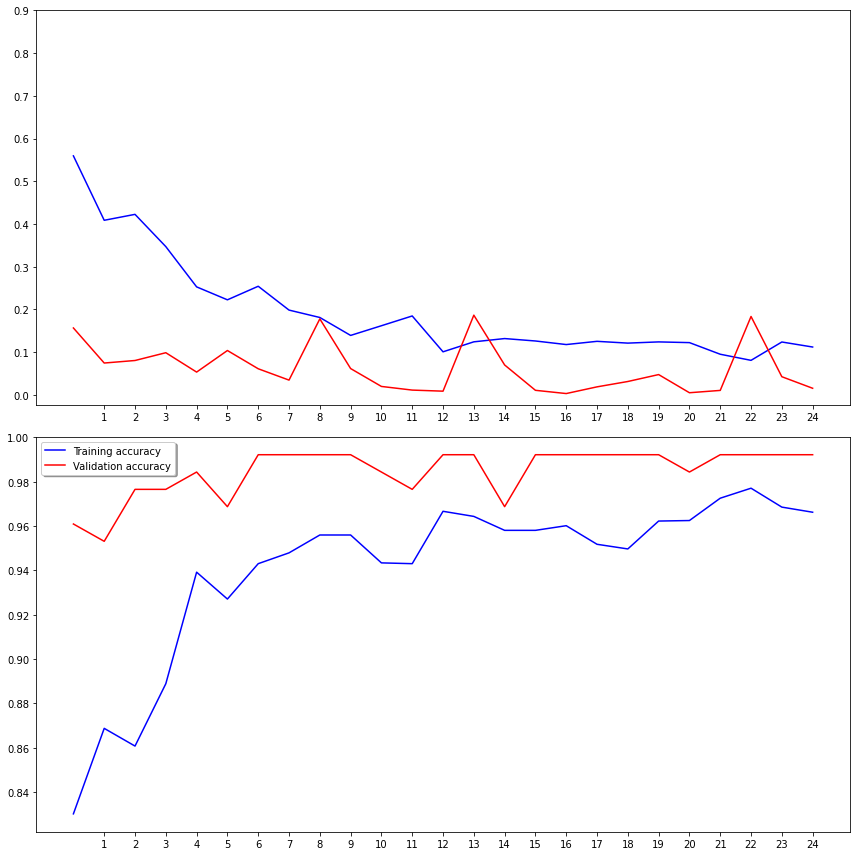

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(H.history['loss'], color='b', label="Training loss")
ax1.plot(H.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, numOfEpoch, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(H.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(H.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, numOfEpoch, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
score,acc = model.evaluate(X_test/255.0, y_test)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

128/128 [==============================] - 1s 9ms/step
score: 0.05
acc: 0.99
